# Cleaning the LAMOST DR8 Dataset

In [1]:
# importing required packages
from astropy.table import Table
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import os

In [2]:
# importing tables
start = time()
os.chdir('/arc/projects/k-pop/catalogues/')
lrs = Table.read('lamost-lrs-dr8v2.fits').to_pandas() # General LRS catalogue (no labels)
mrs = Table.read('lamost-mrs-dr8v2.fits').to_pandas() # General MRS catalogue (no labels)
lrsparamp = Table.read('lamost-param/dr8_v2_LRS_stellar.fits').to_pandas() # LRS parameter catalogue (AGKM)
lrsm = Table.read('lamost-param/dr8_v2_LRS_mstellar.fits').to_pandas() # LRS M class stars (dwarfs or giants)
# lrsmec = Table.read('lamost-param/dr8_v2_LRS_mec.fits').to_pandas() # LRS Multi-Epoch Catalogue
mrsparamp = Table.read('lamost-param/dr8_v2_MRS_stellar.fits').to_pandas() # MRS parameter catalogue
# mrsmec = Table.read('lamost-param/dr8_v2_MRS_mec.fits').to_pandas() # MRS Multi-Epoch Catalogue
end = time()
print('Time Elapsed:',round(end-start,1),'s')

Time Elapsed: 137.5 s


Lets start first with the low resolution spectra,

The descriptions of the columns in the lrs are given from this webpage: [LAMOST LRS General Catalogue](http://www.lamost.org/dr8/v2.0/doc/lr-data-production-description#S3.1)

In [3]:
lrsstars = lrs[lrs['class'] == b'STAR'] # selecting only stars

In [4]:
lrsparamp['subclass'].unique() # checking star subclasses in each table

array([b'F5', b'G7', b'F0', b'G2', b'G3', b'K0', b'F6', b'F9', b'F8',
       b'F2', b'F7', b'G6', b'F3', b'A7', b'K1', b'K3', b'G8', b'G5',
       b'K7', b'G0', b'A1', b'K5', b'A3', b'K2', b'G4', b'G1', b'G9',
       b'K4', b'A5', b'F4', b'A6', b'A9', b'A8', b'A2', b'A0'],
      dtype=object)

Every source has a subclass label in lrsparamp

In [5]:
# lrsm['subclass'].unique()

In [6]:
lrsstars['subclass'].unique()

array([b'G7', b'K7', b'G0', b'dM4', b'F9', b'A2', b'K5', b'K3', b'A9',
       b'F6', b'F5', b'G3', b'G9', b'G6', b'G2', b'G8', b'F2', b'dM0',
       b'A6', b'G5', b'dM2', b'A7', b'WD', b'F0', b'G4', b'F7', b'dM1',
       b'K1', b'B9', b'F4', b'B6', b'K4', b'K0', b'dM5', b'A0', b'F8',
       b'K2', b'A1', b'A3', b'F3', b'Carbon', b'G1', b'sdM0', b'dM3',
       b'DoubleStar', b'A5', b'gM6', b'gM3', b'dM6', b'sdM1', b'A8',
       b'sdM4', b'dM7', b'CV', b'dM8', b'EM', b'dM9', b'sdM3', b'sdM2',
       b'gM1', b'gM8', b'gM0', b'gM7', b'gM4', b'gM5', b'O', b'gM2',
       b'gM9', b'sdM6', b'L0', b'B', b'sdM5', b'A', b'OB', b'CarbonWD',
       b'sdM7', b'G', b'F', b'dK7', b'sdM8'], dtype=object)

Check to make sure that the AFGK catalogue is a subset of the general catalogue with cuts made such that the stellar labels are the same.

In [7]:
A = lrsparamp['obsid'].values
B = lrsstars['obsid'].values
if(set(A).issubset(set(B))):
    print("Yes, column is subset of other.")

Yes, column is subset of other.


So if this is the case, then there is no need to use the general catalogue to make cuts, because there exist no stellar labels for the stars that are a part of the general catalogue and not a part of the AFGK catalogue. \
Therefore to get the "normal" stars, i.e. no white dwarfs, variables, drawfs, or giants, we can just use the AFGK stars as there are no labels for the other ones in the general catalogue.

<!-- Selection criteria of this catalogue: S/N in g band larger than 6 in dark nights, S/N in g band larger than 15 in bright nights -->

In [20]:
# 20 snr cut from Green et al. 2020 (https://arxiv.org/pdf/2006.16258.pdf)
lrsparamp_n = lrsparamp[(lrsparamp['snru'] > 20) | (lrsparamp['snrg'] > 20) | (lrsparamp['snrr'] > 20) | (lrsparamp['snri'] > 20) | (lrsparamp['snrz'] > 20)]
# remove -9999 vals and cuts from analysis by Li et al. 2022 (https://arxiv.org/pdf/2207.05294.pdf)
lrsparamp_n = lrsparamp[(lrsparamp['teff_err'] <= 200) & (lrsparamp['logg_err'] <= 0.2) & \
                      (lrsparamp['feh_err'] <= 0.2) & (lrsparamp['teff_err'] > 0) & (lrsparamp['rv_err'] > 0) & \
                      (lrsparamp['logg_err'] > 0) & (lrsparamp['feh_err'] > 0) & (lrsparamp['alpha_m_err'] > 0)]

In [21]:
lrsparamp_n.describe()

,obsid,gp_id,lmjd,mjd,spid,fiberid,ra_obs,dec_obs,snru,snrg,...,teff,teff_err,logg,logg_err,feh,feh_err,rv,rv_err,alpha_m,alpha_m_err
count,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,...,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06,3.798702e+06
mean,3.491230e+08,1.793230e+18,5.718871e+04,5.718771e+04,8.427859e+00,1.263110e+02,1.453692e+02,2.622624e+01,1.085497e+01,6.772919e+01,...,5.807516e+03,3.948769e+01,3.938273e+00,5.703599e-02,-2.384415e-01,3.663981e-02,-7.699370e+00,4.811337e+00,9.116504e-02,3.780709e-02
std,2.066885e+08,1.433328e+18,7.440664e+02,7.440664e+02,4.555497e+00,7.070105e+01,9.185489e+01,1.684169e+01,1.925157e+02,5.816881e+01,...,5.877623e+02,1.900635e+01,6.144711e-01,3.068614e-02,3.409457e-01,2.164266e-02,4.604661e+01,1.586026e+00,1.523975e-01,2.002941e-02
min,1.010080e+05,1.010270e+05,5.585900e+04,5.585800e+04,1.000000e+00,1.000000e+00,3.530000e-04,-9.821160e+00,-9.999000e+03,7.390000e+00,...,4.019080e+03,1.290000e+00,1.440000e-01,2.000000e-03,-2.499000e+00,1.000000e-03,-4.984800e+02,2.300000e-01,-6.000000e-01,2.970000e-03
25%,1.833102e+08,5.806262e+17,5.662100e+04,5.662000e+04,5.000000e+00,6.500000e+01,7.987409e+01,1.316007e+01,4.380000e+00,3.189000e+01,...,5.378600e+03,2.686000e+01,3.958000e+00,3.800000e-02,-4.130000e-01,2.200000e-02,-3.167000e+01,3.720000e+00,-1.448300e-02,2.262500e-02
50%,3.106042e+08,1.376615e+18,5.705500e+04,5.705400e+04,8.000000e+00,1.260000e+02,1.232308e+02,2.580544e+01,8.440000e+00,4.973000e+01,...,5.769000e+03,3.324000e+01,4.164000e+00,4.700000e-02,-2.000000e-01,2.900000e-02,-7.240000e+00,4.440000e+00,7.925800e-02,3.249000e-02
75%,4.872041e+08,3.237535e+18,5.772300e+04,5.772200e+04,1.200000e+01,1.870000e+02,2.072155e+02,3.986660e+01,1.708000e+01,8.111000e+01,...,6.156160e+03,4.704000e+01,4.322000e+00,6.700000e-02,-4.000000e-03,4.600000e-02,1.791000e+01,5.560000e+00,1.790480e-01,4.809900e-02
max,8.240162e+08,6.916033e+18,5.899700e+04,5.899600e+04,1.600000e+01,2.500000e+02,3.599999e+02,8.807654e+01,4.785600e+02,9.990000e+02,...,7.499990e+03,1.521800e+02,4.900000e+00,1.990000e-01,4.990000e-01,1.470000e-01,4.981000e+02,8.444000e+01,5.999990e-01,1.000000e-01


3798702 all cuts
6342642 no alpha cut
3798702 no rv cut
6342657 neither

 There are total 32%, 60%, and 78% of stars
with the error of Teff ≤ 100 K / logg ≤ 0.1 / [Fe/H] ≤ 0.1, the error of Tef f ≤ 200 K / logg ≤ 0.2 /
[Fe/H] ≤ 0.2, and the error of Tef f ≤ 300 K / logg ≤ 0.3 / [Fe/H] ≤ 0.3 in the AFGK catalogue

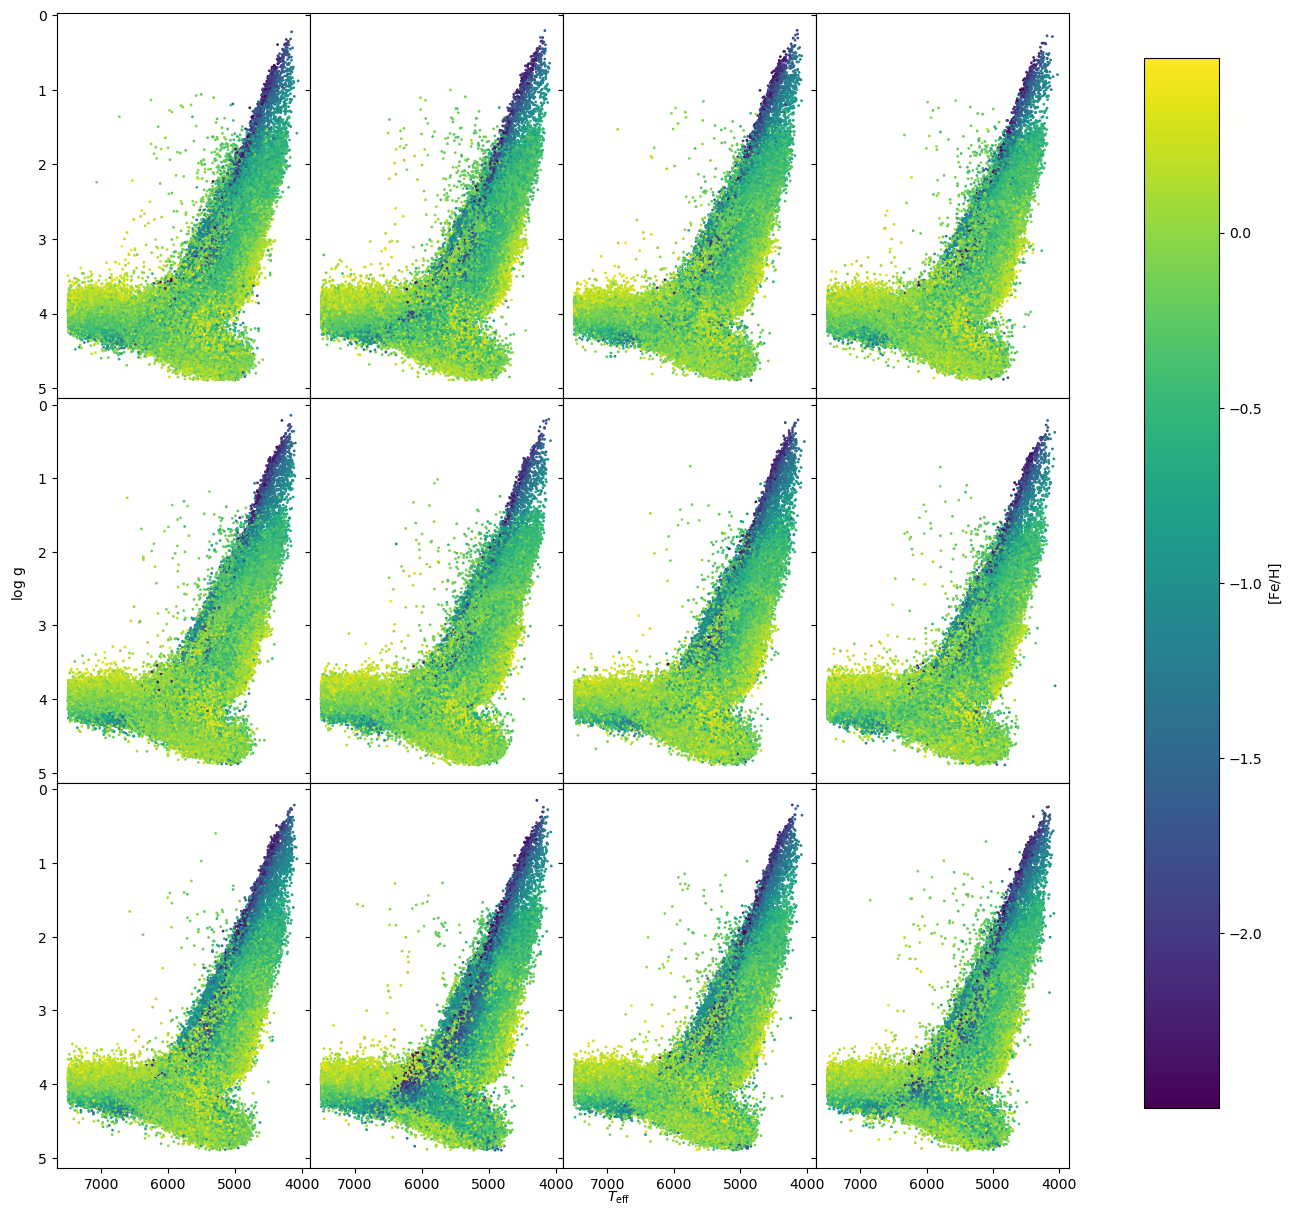

In [10]:
# breaking up the plots because they are too many points
# dfs = np.array_split(lrsparamp[lrsparamp['teff'] <= 7000],24)
dfs = np.array_split(lrsparamp_n,12)

fig = plt.figure(figsize=(15,15))
# plt.title('Selected Stars: %i' %len(df))
gs = fig.add_gridspec(3, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
axs[0,0].invert_yaxis()
axs[0,0].invert_xaxis()
axs[1,0].invert_yaxis()
axs[0,1].invert_xaxis()
axs[2,0].invert_yaxis()
axs[0,2].invert_xaxis()
# axs[3,0].invert_yaxis()
axs[0,3].invert_xaxis()
# axs[0,4].invert_xaxis()
# axs[0,5].invert_xaxis()
fig.text(0.5, 0.09, r'$T_{\rm eff}$', ha='center', va='center')
fig.text(0.1, 0.5, r'${\rm log\ g}$', ha='center', va='center', rotation='vertical')
    
for df,ax in zip(dfs,axs.flat):
    plots = ax.scatter(df['teff'].values, df['logg'].values, c=df['feh'].values, s=1, rasterized=True)
    
fig.subplots_adjust(right=0.8)
cbar = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plots,cax=cbar,label=r'${\rm [Fe/H]}$');

Theres a weird feature at logg 4-5 and teff 8000-9000 when not making a cut on alpha/M error

Save this catalogue as an intermediary table

In [11]:
lrsparamp.columns

Index(['obsid', 'uid', 'gp_id', 'designation', 'obsdate', 'lmjd', 'mjd',
       'planid', 'spid', 'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg',
       'snrr', 'snri', 'snrz', 'class', 'subclass', 'z', 'z_err', 'ps_id',
       'mag_ps_g', 'mag_ps_r', 'mag_ps_i', 'mag_ps_z', 'mag_ps_y',
       'gaia_source_id', 'gaia_g_mean_mag', 'tsource', 'fibertype', 'tfrom',
       'tcomment', 'offsets', 'offsets_v', 'ra', 'dec', 'teff', 'teff_err',
       'logg', 'logg_err', 'feh', 'feh_err', 'rv', 'rv_err', 'alpha_m',
       'alpha_m_err'],
      dtype='object')

In [12]:
lrsparamp['origin'] = 'LAMOST_DR8_LRS'

In [13]:
required_columns = ['gaia_source_id', 'origin', 'obsid', 'ra', 'dec', 'rv', 'rv_err', 'teff', 'teff_err', 
                    'logg', 'logg_err', 'feh', 'feh_err', 'alpha_m', 'alpha_m_err']

In [14]:
lrsparamp = lrsparamp[required_columns]

In [15]:
#Change columns names 
final_columns_names = ['dr3_source_id', 'origin', 'origin_id', 'ra', 'dec', 'rv', 'e_rv', 'teff', 'e_teff', 
                    'logg', 'e_logg', 'feh', 'e_feh', 'alpha_fe', 'e_alpha_fe']

In [16]:
lrsparamp.columns = [final_columns_names]

In [17]:
lrsparamp.dropna(inplace=True)

In [18]:
os.chdir('/arc/projects/k-pop/catalogues/calsurvey')

In [19]:
# lrsparamp.to_parquet('lamost_dr8_lrs_filtered_intermediary.parquet', index=False)

Now I get to check the Giants and dwarfs catalogue:

In [20]:
lrsm.columns

Index(['obsid', 'uid', 'gp_id', 'designation', 'obsdate', 'lmjd', 'mjd',
       'planid', 'spid', 'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg',
       'snrr', 'snri', 'snrz', 'class', 'subclass', 'z', 'z_err', 'ps_id',
       'mag_ps_g', 'mag_ps_r', 'mag_ps_i', 'mag_ps_z', 'mag_ps_y',
       'gaia_source_id', 'gaia_g_mean_mag', 'tsource', 'fibertype', 'tfrom',
       'tcomment', 'offsets', 'offsets_v', 'ra', 'dec', 'teff', 'teff_err',
       'logg', 'logg_err', 'm_h', 'm_h_err', 'ewha', 'ewha_err', 'tio5',
       'cah2', 'cah3', 'tio1', 'tio2', 'tio3', 'tio4', 'cah1', 'caoh',
       'tio5_err', 'cah2_err', 'cah3_err', 'tio1_err', 'tio2_err', 'tio3_err',
       'tio4_err', 'cah1_err', 'caoh_err', 'zeta', 'zeta_err', 'type', 'na'],
      dtype='object')

In [21]:
A = lrsm['obsid'].values
B = lrsstars['obsid'].values
if(set(A).issubset(set(B))):
    print("Yes, column is subset of other.")

Yes, column is subset of other.


(6.0, 0.0)

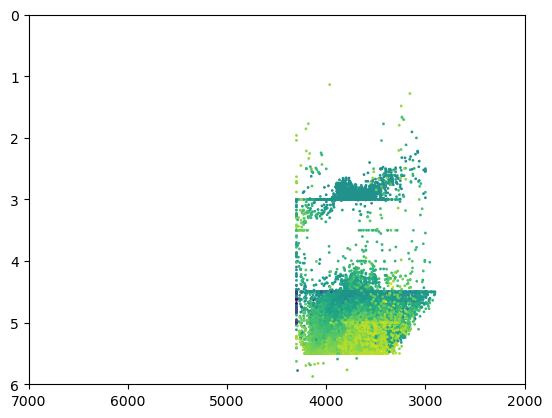

In [22]:
lrsm_n = lrsm[(lrsm['teff'] > 0) & (lrsm['teff_err'] <= 200) & (lrsm['logg_err'] <= 0.2) & \
              (lrsm['m_h_err'] <= 0.2) & (lrsm['teff_err'] > 0) & \
              (lrsm['logg_err'] > 0) & (lrsm['m_h_err'] > 0) & (lrsm['zeta_err'] > 0)]
plt.scatter(lrsm_n['teff'].values, lrsm_n['logg'].values, c=lrsm_n['m_h'].values, s=1, rasterized=True)
# plt.gca().invert_xaxis()
plt.xlim(7000,2000)
plt.ylim(6,0)
# plt.gca().invert_yaxis()

In [23]:
lrsm[lrsm['teff'] > 0]['teff'].value_counts()

3700.000000    9964
3800.000000    6042
3600.000000    5159
3500.000000    3194
3400.000000    1527
               ... 
3286.879883       1
2965.719971       1
3058.489990       1
3198.550049       1
4150.709961       1
Name: teff, Length: 92742, dtype: int64

In [24]:
lrsm['logg'][lrsm['teff'] > 0].value_counts()

5.000    39139
4.500    26489
3.000     7928
5.500     4476
5.001     1392
         ...  
1.238        1
3.411        1
0.920        1
1.297        1
0.651        1
Name: logg, Length: 4953, dtype: int64

In [25]:
# lrsm[lrsm['snrg'] > 15].describe()
# lrsm.describe()

In [26]:
# lrsparamp.describe()

Now, we need to xmatch the lrs catalogue with a different LAMOST DR8 catalogue, so that I can make see how the data looks on a Kiel diagram. I did not find any release papers other then the catalogue descriptions on the website: [Release Note from LAMOST DR8](http://www.lamost.org/dr8/v2.0/doc/release-note)

[LAMOST MRS General Catalogue](http://www.lamost.org/dr8/v2.0/doc/mr-data-production-description#s3.1)

In [27]:
mrsrv = mrs[mrs['snr'] > 20]
# mrsrv = mrsrv[mrsrv['rv_r_flag'] == 0]
# mrsrv = mrsrv[mrsrv['rv_br_flag'] == 0]

In [28]:
mrs.describe()

,obsid,gp_id,lmjd,mjd,spid,fiberid,lmjm,ra_obs,dec_obs,snr,...,rv_lasp0,rv_lasp0_err,rv_lasp1,rv_lasp1_err,coadd,fibermask,bad_b,bad_r,moon_angle,lunardate
count,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,...,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07,2.214164e+07
mean,7.194567e+08,1.603718e+18,5.854240e+04,5.854140e+04,8.443599e+00,1.262685e+02,6.646305e+07,1.383609e+02,3.133406e+01,2.814502e+01,...,-7.331540e+03,-7.448542e+03,-7.371238e+03,-7.294069e+03,2.115885e-01,-2.114671e+03,2.162216e-03,1.535569e-06,6.235328e+01,1.489668e+01
std,6.709425e+07,1.373393e+18,2.952886e+02,2.952886e+02,4.545599e+00,7.162256e+01,3.443306e+07,8.898763e+01,1.757310e+01,4.632590e+01,...,3.629788e+03,3.604628e+03,3.620337e+03,3.777694e+03,4.084346e-01,4.084470e+03,4.644934e-02,1.239180e-03,2.640248e+02,4.620567e+00
min,5.889020e+08,5.889020e+08,5.802500e+04,5.802400e+04,1.000000e+00,1.000000e+00,0.000000e+00,1.793000e-04,-9.999039e+00,0.000000e+00,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,-9.999000e+03,0.000000e+00,0.000000e+00,-9.999000e+03,7.000000e+00
25%,6.673022e+08,4.502320e+17,5.827200e+04,5.827100e+04,4.000000e+00,6.400000e+01,8.364396e+07,7.210190e+01,1.840161e+01,1.490000e+00,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.310000e+01,1.100000e+01
50%,7.193091e+08,1.247079e+18,5.850800e+04,5.850700e+04,8.000000e+00,1.260000e+02,8.417091e+07,1.218255e+02,3.128316e+01,1.178000e+01,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.510000e+01,1.500000e+01
75%,7.755082e+08,3.131085e+18,5.883000e+04,5.882900e+04,1.200000e+01,1.880000e+02,8.467506e+07,1.887631e+02,4.455772e+01,3.571000e+01,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.180000e+01,1.800000e+01
max,8.267162e+08,6.917511e+18,5.901600e+04,5.901500e+04,1.600000e+01,2.500000e+02,8.498322e+07,3.599999e+02,8.044320e+01,9.990000e+02,...,4.981800e+02,9.999000e+01,4.995700e+02,9.999000e+03,1.000000e+00,2.420000e+02,1.000000e+00,1.000000e+00,1.732000e+02,2.400000e+01


In [29]:
mrsrv.describe()

,obsid,gp_id,lmjd,mjd,spid,fiberid,lmjm,ra_obs,dec_obs,snr,...,rv_lasp0,rv_lasp0_err,rv_lasp1,rv_lasp1_err,coadd,fibermask,bad_b,bad_r,moon_angle,lunardate
count,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,...,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06,8.500304e+06
mean,7.192768e+08,1.677401e+18,5.854520e+04,5.854420e+04,8.366977e+00,1.261691e+02,6.005333e+07,1.385751e+02,3.176906e+01,6.742048e+01,...,-6.018128e+03,-6.139991e+03,-6.069585e+03,-5.999300e+03,2.876687e-01,-2.875049e+03,5.354985e-03,3.999857e-06,7.113369e+01,1.470342e+01
std,6.747462e+07,1.370434e+18,2.966637e+02,2.966637e+02,4.530615e+00,7.108332e+01,3.816465e+07,9.299513e+01,1.688303e+01,6.215049e+01,...,4.815251e+03,4.784281e+03,4.800314e+03,4.996489e+03,4.526758e-01,4.527180e+03,7.298157e-02,1.999960e-03,3.317440e+01,4.682372e+00
min,5.889020e+08,5.889020e+08,5.802500e+04,5.802400e+04,1.000000e+00,1.000000e+00,0.000000e+00,1.793000e-04,-9.999039e+00,2.001000e+01,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,-9.999000e+03,0.000000e+00,0.000000e+00,-9.999000e+03,7.000000e+00
25%,6.812051e+08,4.571816e+17,5.840900e+04,5.840800e+04,4.000000e+00,6.400000e+01,0.000000e+00,7.012786e+01,1.997136e+01,3.022000e+01,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,-9.999000e+03,0.000000e+00,0.000000e+00,4.590000e+01,1.100000e+01
50%,7.188020e+08,1.384529e+18,5.850700e+04,5.850600e+04,8.000000e+00,1.270000e+02,8.412752e+07,1.136556e+02,3.178733e+01,4.680000e+01,...,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.680000e+01,1.500000e+01
75%,7.750052e+08,3.234270e+18,5.882900e+04,5.882800e+04,1.200000e+01,1.870000e+02,8.466458e+07,1.915857e+02,4.431805e+01,8.009000e+01,...,-2.030000e+01,7.400000e-01,-1.891000e+01,1.210000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.180000e+01,1.800000e+01
max,8.267162e+08,6.917511e+18,5.901600e+04,5.901500e+04,1.600000e+01,2.500000e+02,8.498322e+07,3.599999e+02,8.044320e+01,9.990000e+02,...,4.981800e+02,9.999000e+01,4.995700e+02,9.999000e+03,1.000000e+00,2.420000e+02,1.000000e+00,1.000000e+00,1.732000e+02,2.400000e+01


In [30]:
mrs['rv_r_flag'].value_counts()

 0       16167608
-9999     5733967
 2         168776
 1          52163
 3          19121
Name: rv_r_flag, dtype: int64

In [31]:
mrs['rv_br_flag'].value_counts()

 0       15053974
-9999     6971569
 2          55718
 1          30222
 3          30152
Name: rv_br_flag, dtype: int64

isochrones to determine stellar pops: x axis: g-r, y-axis: r, check other g-'s

In [32]:
len(mrsrv)

8500304

In [33]:
mrsparamp.columns

Index(['mobsid', 'obsid', 'uid', 'gp_id', 'designation', 'obsdate', 'lmjd',
       'mjd', 'planid', 'spid', 'fiberid', 'lmjm', 'band', 'ra_obs', 'dec_obs',
       'snr', 'gaia_source_id', 'gaia_g_mean_mag', 'gaia_bp_mean_mag',
       'gaia_rp_mean_mag', 'tsource', 'fibertype', 'tfrom', 'tcomment',
       'offsets', 'offsets_v', 'ra', 'dec', 'teff_lasp', 'teff_lasp_err',
       'logg_lasp', 'logg_lasp_err', 'feh_lasp', 'feh_lasp_err', 'vsini_lasp',
       'vsini_lasp_err', 'rv_b0', 'rv_b0_err', 'rv_b1', 'rv_b1_err',
       'rv_b_flag', 'rv_r0', 'rv_r0_err', 'rv_r1', 'rv_r1_err', 'rv_r_flag',
       'rv_br0', 'rv_br0_err', 'rv_br1', 'rv_br1_err', 'rv_br_flag',
       'rv_lasp0', 'rv_lasp0_err', 'rv_lasp1', 'rv_lasp1_err', 'coadd',
       'fibermask', 'alpha_m_cnn', 'teff_cnn', 'logg_cnn', 'feh_cnn', 'c_fe',
       'n_fe', 'o_fe', 'mg_fe', 'al_fe', 'si_fe', 's_fe', 'ca_fe', 'ti_fe',
       'cr_fe', 'ni_fe', 'cu_fe', 'alpha_m_lasp', 'alpha_m_lasp_err',
       'moon_angle', 'lunardate', 'mo

In [34]:
lrsparamp.columns

MultiIndex([('dr3_source_id',),
            (       'origin',),
            (    'origin_id',),
            (           'ra',),
            (          'dec',),
            (           'rv',),
            (         'e_rv',),
            (         'teff',),
            (       'e_teff',),
            (         'logg',),
            (       'e_logg',),
            (          'feh',),
            (        'e_feh',),
            (     'alpha_fe',),
            (   'e_alpha_fe',)],
           )

In [35]:
mrs.columns

Index(['mobsid', 'obsid', 'uid', 'gp_id', 'designation', 'obsdate', 'lmjd',
       'mjd', 'planid', 'spid', 'fiberid', 'lmjm', 'band', 'ra_obs', 'dec_obs',
       'snr', 'gaia_source_id', 'gaia_g_mean_mag', 'gaia_bp_mean_mag',
       'gaia_rp_mean_mag', 'tsource', 'fibertype', 'tfrom', 'tcomment',
       'offsets', 'offsets_v', 'ra', 'dec', 'rv_b0', 'rv_b0_err', 'rv_b1',
       'rv_b1_err', 'rv_b_flag', 'rv_r0', 'rv_r0_err', 'rv_r1', 'rv_r1_err',
       'rv_r_flag', 'rv_br0', 'rv_br0_err', 'rv_br1', 'rv_br1_err',
       'rv_br_flag', 'rv_lasp0', 'rv_lasp0_err', 'rv_lasp1', 'rv_lasp1_err',
       'coadd', 'fibermask', 'bad_b', 'bad_r', 'moon_angle', 'lunardate',
       'moon_flg'],
      dtype='object')

In [36]:
!ls -lhtr

total 278M
-rw-r--r--. 1 sfabbro    sfabbro     140 Dec  6 14:19 columns.txt
-rw-r--r--. 1 sfabbro    sfabbro    774K Dec  6 14:48 galah.ipynb
-rw-r--r--. 1 fgran      fgran       48M Dec  6 15:26 apogee_dr17_filtered.parquet
-rwxrwxrwx. 1 fgran      fgran      270K Dec  6 15:46 APOGEE_selection_sos.ipynb
-rw-rwxr--+ 1 sfabbro    sfabbro     30M Dec  6 15:57 galah_dr3_filtered.parquet
-rwxrwxrwx. 1 fgran      fgran       14K Dec 15 20:23 Remove_binaries_variables.ipynb
-rw-rw-r--+ 1 aydanmckay aydanmckay 198M Dec 16 07:20 lamost_dr8_lrs_filtered_intermediary.parquet
-rw-r--r--+ 1 aydanmckay aydanmckay 1.6M Dec 16 07:39 lamostdr8.ipynb
